In [397]:
from os import path
import tempfile

import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
ophys_client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")
em_client = EMClient()

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [399]:
coreg_table = em_client.get_coregistration_table()
coreg_table.drop_duplicates("pt_root_id", inplace=True)
print(len(coreg_table))
coreg_table.head()

48


,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,...,score,pt_position,bb_start_position,bb_end_position,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,277703,2022-02-04 06:24:15.742387+00:00,t,279.238104,92055099945612303,864691132710145793,1,2023-02-14 16:50:14.491563+00:00,t,277703,...,NaN,"[794469, 608850, 265500]","[789813, 605047, 28149]","[799901, 612885, 29027]",M409828_13_3_14,"[797.7329658575621, 268.4703958902916, 92.8290...",submitted,True,not_started,True
1,277515,2022-02-04 06:26:06.653170+00:00,t,329.847534,93180175218565442,864691132760377194,2,2023-02-14 16:50:14.492369+00:00,t,277515,...,NaN,"[834898, 578974, 258390]","[829699, 575016, 27320]","[840253, 582931, 28368]",M409828_13_1_60,"[838.0087061146714, 237.58057806602417, 93.975...",submitted,True,not_started,True
2,277213,2022-02-04 06:30:33.362739+00:00,t,313.577943,91843581329183083,864691132720617684,3,2023-02-14 16:50:14.493215+00:00,t,277213,...,NaN,"[786864, 593718, 243945]","[782441, 588906, 25792]","[791287, 598451, 26699]",M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,True
3,293528,2022-02-04 06:22:30.509490+00:00,t,332.374686,91070624654826905,864691132741334425,4,2023-02-14 16:50:14.494034+00:00,t,293528,...,NaN,"[759859, 632673, 243810]","[755436, 627939, 25734]","[764515, 637174, 26753]",M409828_13_5_119,"[763.2087486129211, 285.7899063229709, 65.5534...",submitted,True,submitted,True
4,277969,2022-02-04 06:21:54.350553+00:00,t,313.560871,92547337557612090,864691132771662867,5,2023-02-14 16:50:14.494820+00:00,t,277969,...,NaN,"[812705, 597132, 270405]","[808514, 592554, 28683]","[817050, 601866, 29619]",M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,True


In [400]:
cell_types = em_client.get_cell_type_table()
cell_types.head()

,index,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,...,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1132,2022-04-20 02:59:02+00:00,t,350562,coarse_manual,PYC,350562,2022-02-04 06:21:10.300143+00:00,t,...,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]","[897.0749802589321, 115.14175620165939, 29.457...",not_started,False,not_started,False
1,1,214,2022-04-20 02:59:02+00:00,t,383955,coarse_manual,PYC,383955,2022-02-04 06:21:10.432163+00:00,t,...,95649060060623076,864691132569667100,"[920802, 795478, 329220]","[914826, 790822, 34920]","[926389, 800366, 36123]","[925.0443716838962, 464.7133252652253, 104.265...",not_started,False,not_started,False
2,2,13,2022-04-20 02:59:02+00:00,t,385028,coarse_manual,PYC,385028,2022-02-04 06:21:10.464813+00:00,t,...,95863052645657911,864691132781402571,"[929338, 898530, 386595]","[924914, 892245, 41162]","[933994, 903885, 42103]","[934.1509524083707, 579.3191946675782, 131.960...",not_started,False,not_started,False
3,3,717,2022-04-20 02:59:02+00:00,t,293764,coarse_manual,PYC,293764,2022-02-04 06:21:10.538881+00:00,t,...,94450111081742956,864691132625300120,"[878665, 697702, 245475]","[874009, 694365, 26030]","[883554, 701349, 26859]","[882.3273740159212, 348.2992615823263, 49.7502...",submitted,True,submitted,True
4,4,2604,2022-04-20 02:59:02+00:00,t,351373,coarse_manual,PYC,351373,2022-02-04 06:21:10.585360+00:00,t,...,96276193669654108,864691132689074198,"[944314, 572378, 210330]","[939814, 568187, 22179]","[948505, 576413, 23110]","[947.3276783715071, 217.8158197091021, 49.4355...",not_started,False,not_started,False


In [401]:
cell_type_map = pd.Series(index=cell_types.pt_root_id.values, data=cell_types.cell_type.values)
cell_type_map

864691132773514104    PYC
864691132569667100    PYC
864691132781402571    PYC
864691132625300120    PYC
864691132689074198    PYC
                     ... 
864691132735829608     BC
864691132653866455    PYC
864691132617158087    PYC
864691132653436140    PYC
864691132762899335    PYC
Length: 3760, dtype: object

## Cell types of presynaptic cells

In [402]:
# Load the presynaptic synapses
den_syn = em_client.get_dendritic_synapses(coreg_table.pt_root_id.values)

In [403]:
cell_type_map[den_syn.pre_pt_root_id[den_syn.pre_pt_root_id.isin(cell_type_map.index)]].value_counts()

BC              3317
MC              3106
PYC             1153
Unsure I         469
Non-neuronal     182
BPC              112
NGC               47
dtype: int64

In [404]:
columns = ["PYC", "MC", "BC", "BPC", "Other", "Unlabeled", "No Soma Attached"]
presyn_cell_type_counts = pd.DataFrame(index=coreg_table.pt_root_id, columns=columns, data=0)
syn_weight_by_type = pd.DataFrame(index=coreg_table.pt_root_id, columns=columns, data=0)

for root_id in coreg_table.pt_root_id.values:
    syn = den_syn[den_syn.post_pt_root_id == root_id]
    
    # pre_root_ids = syn.pre_pt_root_id.values[~no_soma]
    # has_type = np.isin(pre_root_ids, cell_type_map.index)
    # presyn_cell_type_counts.at[root_id, "Unlabeled"] = (~has_type).sum()
    # pre_root_ids = pre_root_ids[has_type]
    # pre_types = cell_type_map[pre_root_ids]
    # n_other = 0

    for _, row in syn.iterrows():
        w = row["size"]
        pre = row.pre_pt_root_id
        presyn_type = None

        if row.pre_soma_position_microns is None:
            presyn_type = "No Soma Attached"
        else:
            presyn_type = cell_type_map.get(pre, default="Unlabeled")
            if presyn_type not in columns:
                presyn_type = "Other"
        
        presyn_cell_type_counts.at[root_id, presyn_type] += 1
        syn_weight_by_type.at[root_id, presyn_type] += w


presyn_cell_type_counts

,PYC,MC,BC,BPC,Other,Unlabeled,No Soma Attached
pt_root_id,,,,,,,
864691132710145793,37,92,92,5,20,153,3028
864691132760377194,47,110,120,2,28,164,3988
864691132720617684,19,48,65,3,20,138,2896
864691132741334425,16,63,79,1,16,180,2194
864691132771662867,26,104,107,4,22,139,2344
864691132807412738,19,72,80,3,12,190,3111
864691132573738810,11,43,37,3,6,90,1587
864691132594653239,31,93,101,3,9,190,3013
864691133065754585,38,116,111,1,18,177,3238


<Axes: xlabel='post_pt_root_id'>

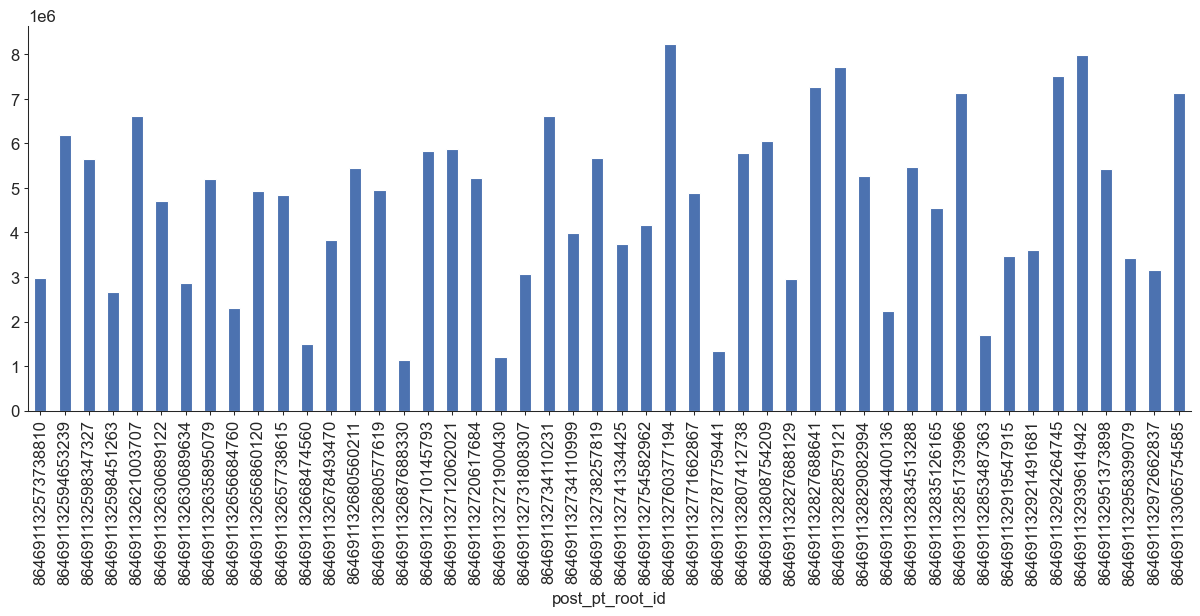

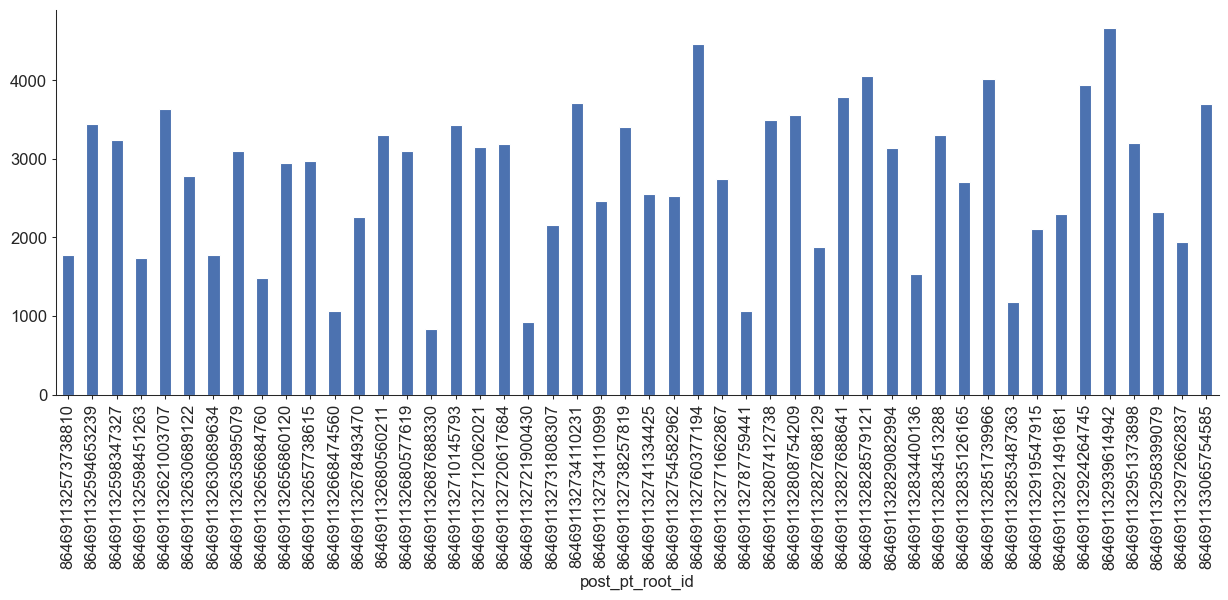

In [405]:
den_syn.groupby("post_pt_root_id")["size"].sum().plot(kind="bar", figsize=(15, 5))
plt.figure()
den_syn.groupby("post_pt_root_id").size().plot(kind="bar", figsize=(15, 5))

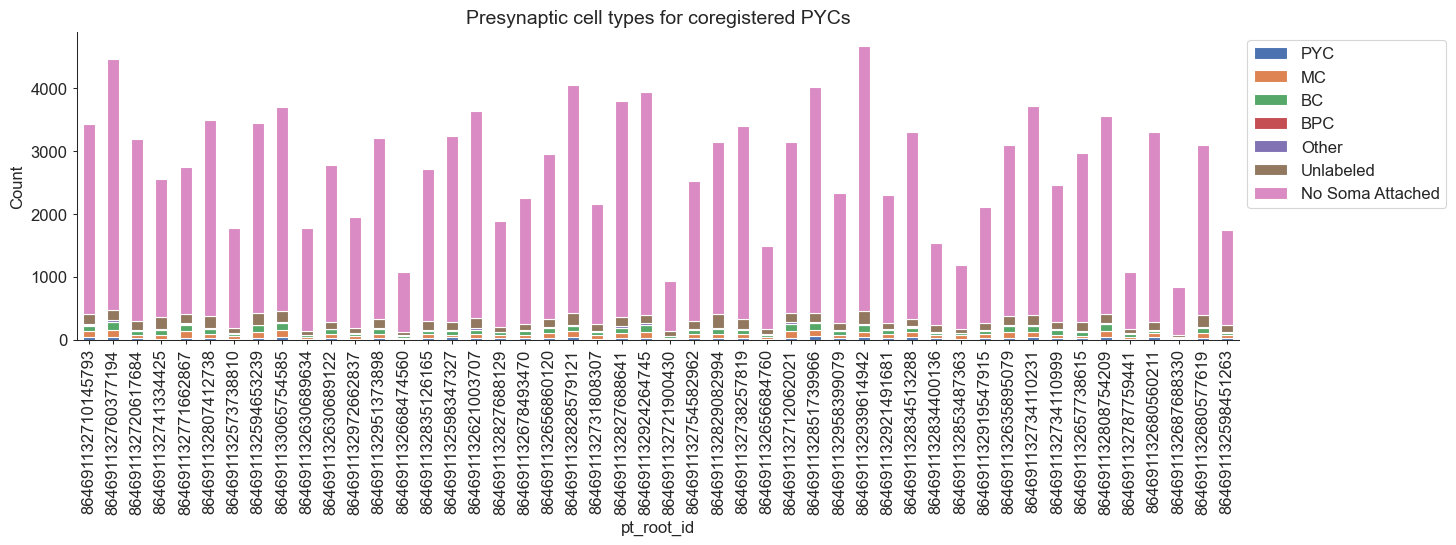

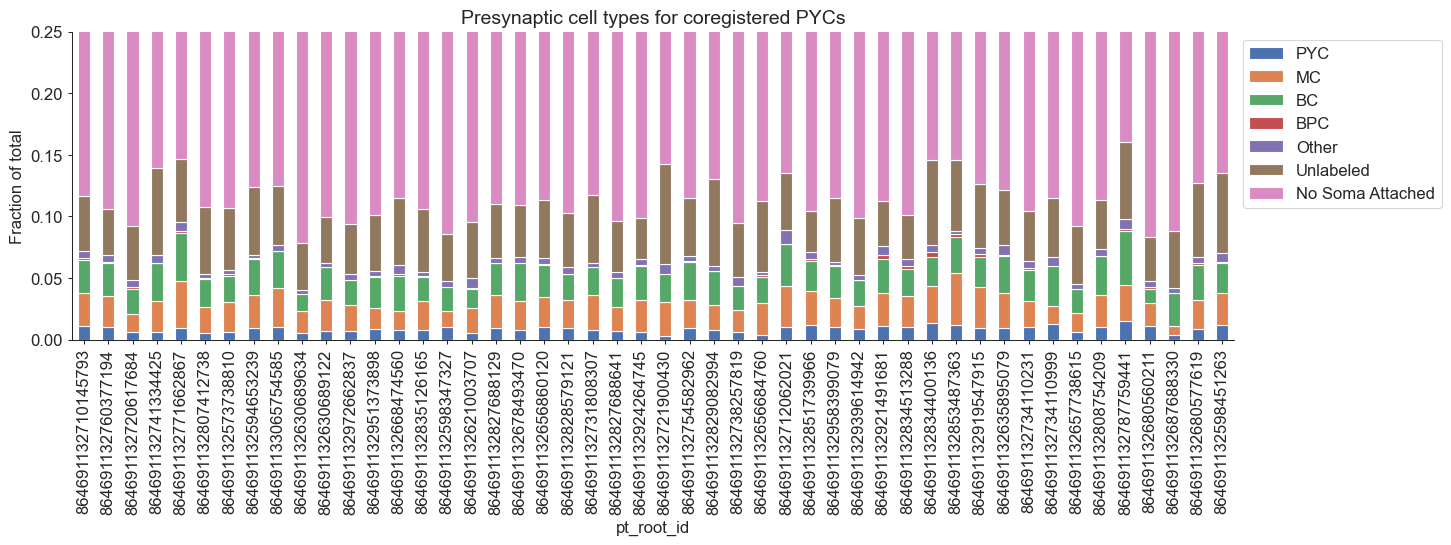

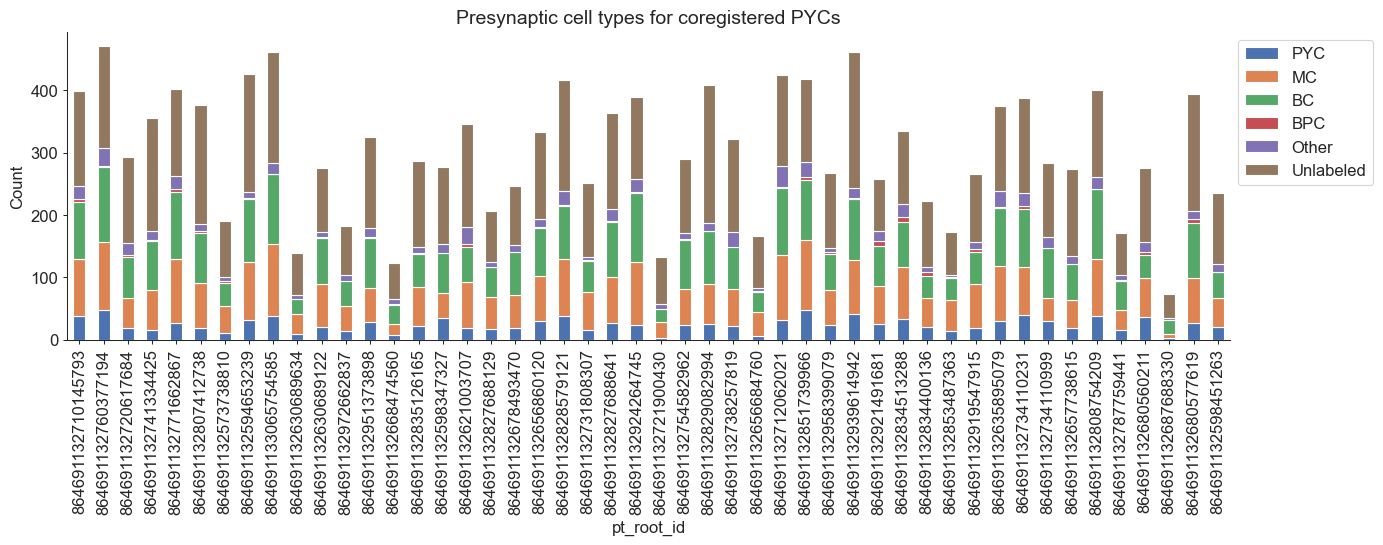

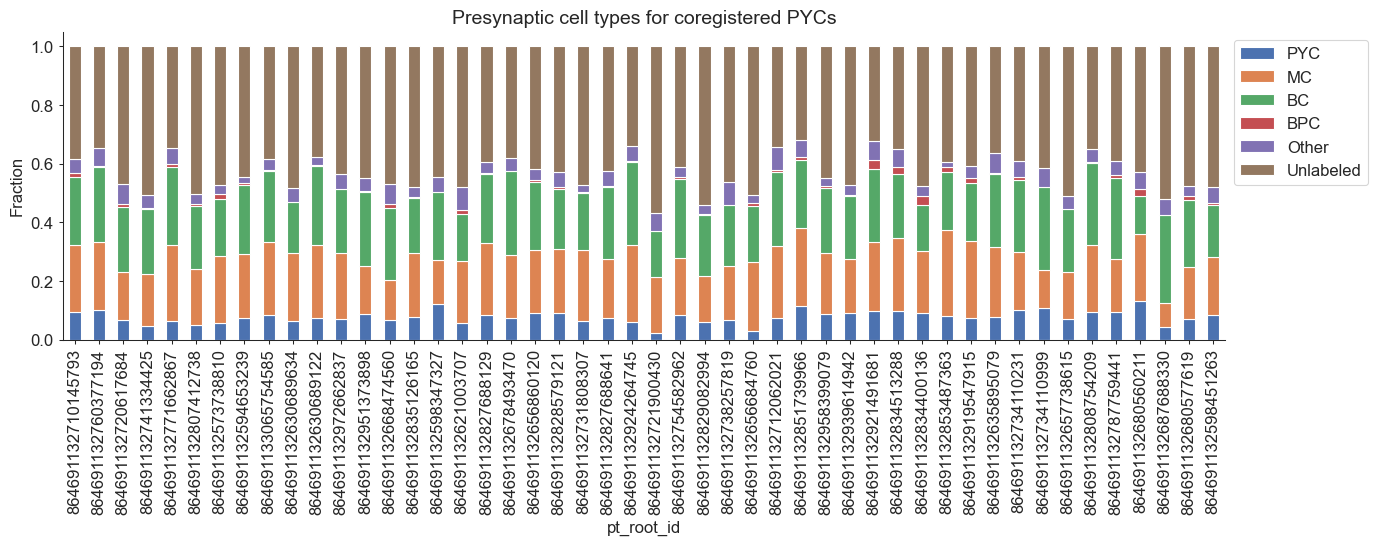

In [406]:
ax = presyn_cell_type_counts.plot(kind="bar", stacked=True, figsize=(15, 4))
ax.set_title("Presynaptic cell types for coregistered PYCs")
ax.set_ylabel("Count")
ax.get_legend().set_bbox_to_anchor((1, 1), transform=ax.transAxes)


ax = presyn_cell_type_counts.divide(presyn_cell_type_counts.sum(axis=1), axis=0).plot(kind="bar", stacked=True, figsize=(15, 4))
ax.set_title("Presynaptic cell types for coregistered PYCs")
ax.set_ylabel("Fraction of total")
ax.set_ylim(0, 0.25)
ax.get_legend().set_bbox_to_anchor((1, 1), transform=ax.transAxes)


presyn_cell_type_counts_in_em = presyn_cell_type_counts[presyn_cell_type_counts.columns[:-1]] # Ignore no soma cells

ax = presyn_cell_type_counts_in_em.plot(kind="bar", stacked=True, figsize=(15, 4))
ax.set_title("Presynaptic cell types for coregistered PYCs")
ax.set_ylabel("Count")
ax.get_legend().set_bbox_to_anchor((1, 1), transform=ax.transAxes)


ax = presyn_cell_type_counts_in_em.divide(presyn_cell_type_counts_in_em.sum(axis=1), axis=0).plot(kind="bar", stacked=True, figsize=(15, 4))
ax.set_title("Presynaptic cell types for coregistered PYCs")
ax.set_ylabel("Fraction")
ax.get_legend().set_bbox_to_anchor((1, 1), transform=ax.transAxes)

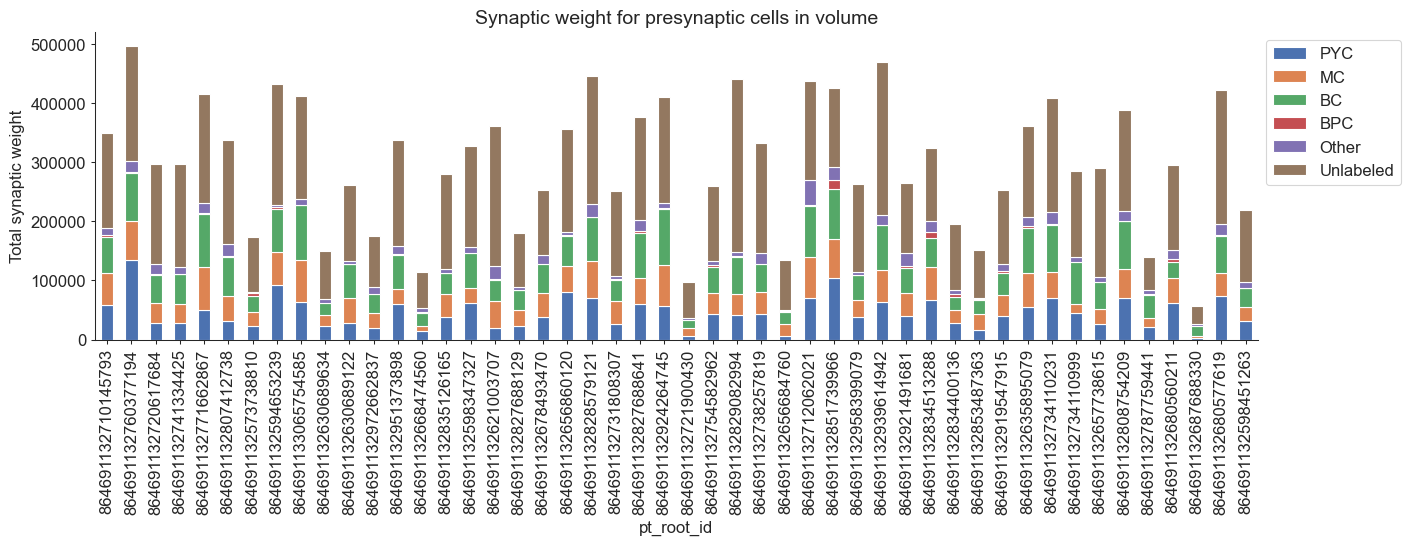

In [407]:
ax = syn_weight_by_type[syn_weight_by_type.columns[:-1]].plot(kind="bar", stacked=True, figsize=(15, 4))
ax.set_title("Synaptic weight for presynaptic cells in volume")
ax.set_ylabel("Total synaptic weight")
ax.get_legend().set_bbox_to_anchor((1, 1), transform=ax.transAxes)

## Load metrics

In [408]:
metrics = at.load_roi_metrics(remove_duplicates=False)
metrics["pt_root_id"] = None # pd.Series(index=coreg_table.roi.values, data=coreg_table.pt_root_id.values)

for roi, root_id in zip(coreg_table.roi.values, coreg_table.pt_root_id.values):
    metrics.at[roi, "pt_root_id"] = root_id

# metrics.loc[coreg_table.roi.values, "pt_root_id"] = coreg_table.pt_root_id.values
metrics.head()

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit,pt_root_id
M409828_11_1_89,409828,1,1,1,89,True,False,False,0,NaN,...,0.001903,0,0,1-1,False,False,-0.043955,30.681108,69.313722,None
M409828_11_2_0,409828,1,1,2,0,True,False,True,2,"M409828_11_2_0, M409828_11_3_2",...,0.002629,0,0,1-2,False,False,-0.073683,61.781378,43.508462,None
M409828_11_2_1,409828,1,1,2,1,True,False,True,2,"M409828_11_2_1, M409828_11_3_0",...,0.002262,0,0,1-2,True,True,-0.011145,20.539986,13.115250,None
M409828_11_2_2,409828,1,1,2,2,True,False,False,0,NaN,...,0.002412,0,0,1-2,True,True,0.278888,360.000000,66.145993,None
M409828_11_2_4,409828,1,1,2,4,True,False,False,0,NaN,...,0.001601,0,0,1-2,False,False,-0.100974,348.754021,307.709808,None


In [409]:
coreg_table.pt_root_id.values

array([864691132710145793, 864691132760377194, 864691132720617684,
       864691132741334425, 864691132771662867, 864691132807412738,
       864691132573738810, 864691132594653239, 864691133065754585,
       864691132630689634, 864691132630689122, 864691132972662837,
       864691132951373898, 864691132668474560, 864691132835126165,
       864691132598347327, 864691132621003707, 864691132827688129,
       864691132678493470, 864691132656860120, 864691132828579121,
       864691132731808307, 864691132827688641, 864691132924264745,
       864691132721900430, 864691132754582962, 864691132829082994,
       864691132738257819, 864691132656684760, 864691132712062021,
       864691132851739966, 864691132958399079, 864691132939614942,
       864691132921491681, 864691132834513288, 864691132834400136,
       864691132853487363, 864691132919547915, 864691132635895079,
       864691132734110231, 864691132734110999, 864691132657738615,
       864691132808754209, 864691132787759441, 864691132680560

In [410]:
metrics_em = metrics[~metrics.pt_root_id.isna()].set_index("pt_root_id")
metrics_em.head()

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
pt_root_id,,,,,,,,,,,,,,,,,,,,,
864691132828579121,409828,1,3,1,40,True,False,True,2,"M409828_13_1_40, M409828_13_2_255",...,0.000980,0.007573,4,200,3-1,False,False,0.467035,235.957198,1.219731e+02
864691132760377194,409828,1,3,1,60,True,False,False,0,NaN,...,0.000568,0.003893,4,200,3-1,False,False,0.463262,349.079239,3.235054e-17
864691132621003707,409828,1,3,1,65,True,False,False,0,NaN,...,0.000544,0.003402,4,200,3-1,False,False,0.543214,49.298832,2.982090e+02
864691132680560211,409828,1,3,1,67,True,False,False,0,NaN,...,0.000770,0.005534,4,200,3-1,False,False,0.630489,238.613347,2.421857e+02
864691132630689634,409828,1,3,1,88,True,False,True,4,"M409828_13_1_88, M409828_13_2_134, M409828_13_...",...,0.000411,0.002847,4,200,3-1,False,False,0.018275,319.991205,3.594287e+01


In [411]:
dgw_resp_root_ids = metrics.pt_root_id[metrics.dgw_frac_responsive_trials >= 0.25].dropna().values.astype(int)
print("n =", len(dgw_resp_root_ids))
dgw_resp_root_ids

n = 31


array([864691132680560211, 864691132851739966, 864691132924264745,
       864691132720617684, 864691132630689122, 864691132573738810,
       864691132771662867, 864691132919547915, 864691132656684760,
       864691132710145793, 864691132835126165, 864691132829082994,
       864691132687688330, 864691132668474560, 864691132808754209,
       864691132594653239, 864691132657738615, 864691132754582962,
       864691133065754585, 864691132712062021, 864691132598451263,
       864691132834513288, 864691132921491681, 864691132972662837,
       864691132958399079, 864691132731808307, 864691132734110231,
       864691132834400136, 864691132656860120, 864691132741334425,
       864691132787759441])

In [412]:
def total_local_input(root_id, local=True, radius=75, cell_type=None):
    syn = den_syn[den_syn.post_pt_root_id == root_id]
    soma_soma_horiz_dist_microns = syn.apply(lambda row: np.inf if row["pre_soma_position_microns"] is None else np.linalg.norm(row["pre_soma_position_microns"][::2] - row["post_soma_position_microns"][::2]), axis=1)
    local_syn = syn[(soma_soma_horiz_dist_microns < radius) if local else (soma_soma_horiz_dist_microns > radius)]

    if cell_type is not None:
        if type(cell_type) is str:
            cell_type = [cell_type]
        local_syn = local_syn[local_syn.pre_pt_root_id.apply(cell_type_map.get).isin(cell_type)]

    return local_syn["size"].sum()

In [222]:
[c for c in metrics.columns if "dgw" in c]

['dgw_pref_response',
 'dgw_pref_dir',
 'dgw_pref_sf',
 'dgw_pref_dir_idx',
 'dgw_pref_sf_idx',
 'dgw_pref_dir_mean',
 'dgw_z_score',
 'dgw_response_p',
 'dgw_osi',
 'dgw_gosi',
 'dgw_dsi',
 'dgw_frac_responsive_trials',
 'dgw_lifetime_sparseness',
 'dgw_p_trial_responses',
 'dgw_sig_trial_responses',
 'dgw_vonmises_0_param_0',
 'dgw_vonmises_0_param_1',
 'dgw_vonmises_0_param_2',
 'dgw_vonmises_0_param_3',
 'dgw_vonmises_0_param_4',
 'dgw_vonmises_0_param_5',
 'dgw_vonmises_0_pref_dir',
 'dgw_vonmises_0_peak_amp',
 'dgw_vonmises_0_r2_score',
 'dgw_vonmises_1_param_0',
 'dgw_vonmises_1_param_1',
 'dgw_vonmises_1_param_2',
 'dgw_vonmises_1_param_3',
 'dgw_vonmises_1_param_4',
 'dgw_vonmises_1_param_5',
 'dgw_vonmises_1_pref_dir',
 'dgw_vonmises_1_peak_amp',
 'dgw_vonmises_1_r2_score',
 'dgw_norm_dir_responses',
 'dgw_pref_ori',
 'dgw_chisq_response_p',
 'dgw_null_dist_multi_mean',
 'dgw_null_dist_multi_std',
 'dgw_null_dist_single_mean',
 'dgw_null_dist_single_std',
 'dgw_resp_pref_dgf'

In [247]:
metrics_em[metrics_em.index.isin(dgw_resp_root_ids)]["dgw_gosi"].sort_values()

pt_root_id
864691132834513288    0.100823
864691132919547915    0.121216
864691132771662867    0.126066
864691132731808307    0.138347
864691132656860120    0.145744
864691132851739966    0.172690
864691132921491681    0.183796
864691132710145793    0.188314
864691132573738810    0.191939
864691133065754585    0.209992
864691132808754209    0.241960
864691132712062021    0.283480
864691132787759441    0.307354
864691132741334425    0.316476
864691132834400136    0.398179
864691132630689122    0.399306
864691132754582962    0.413096
864691132598451263    0.495523
864691132734110231    0.504545
864691132829082994    0.509059
864691132657738615    0.523859
864691132668474560    0.551702
864691132924264745    0.567350
864691132594653239    0.584856
864691132680560211    0.636461
864691132958399079    0.654353
864691132720617684    0.680579
864691132687688330    0.692413
864691132656684760    0.716191
864691132835126165    0.724669
864691132972662837    0.727026
Name: dgw_gosi, dtype: float

In [245]:
sample_root_ids = [864691132687688330]
# 
# 864691132656684760
# 864691132835126165
# 864691132972662837

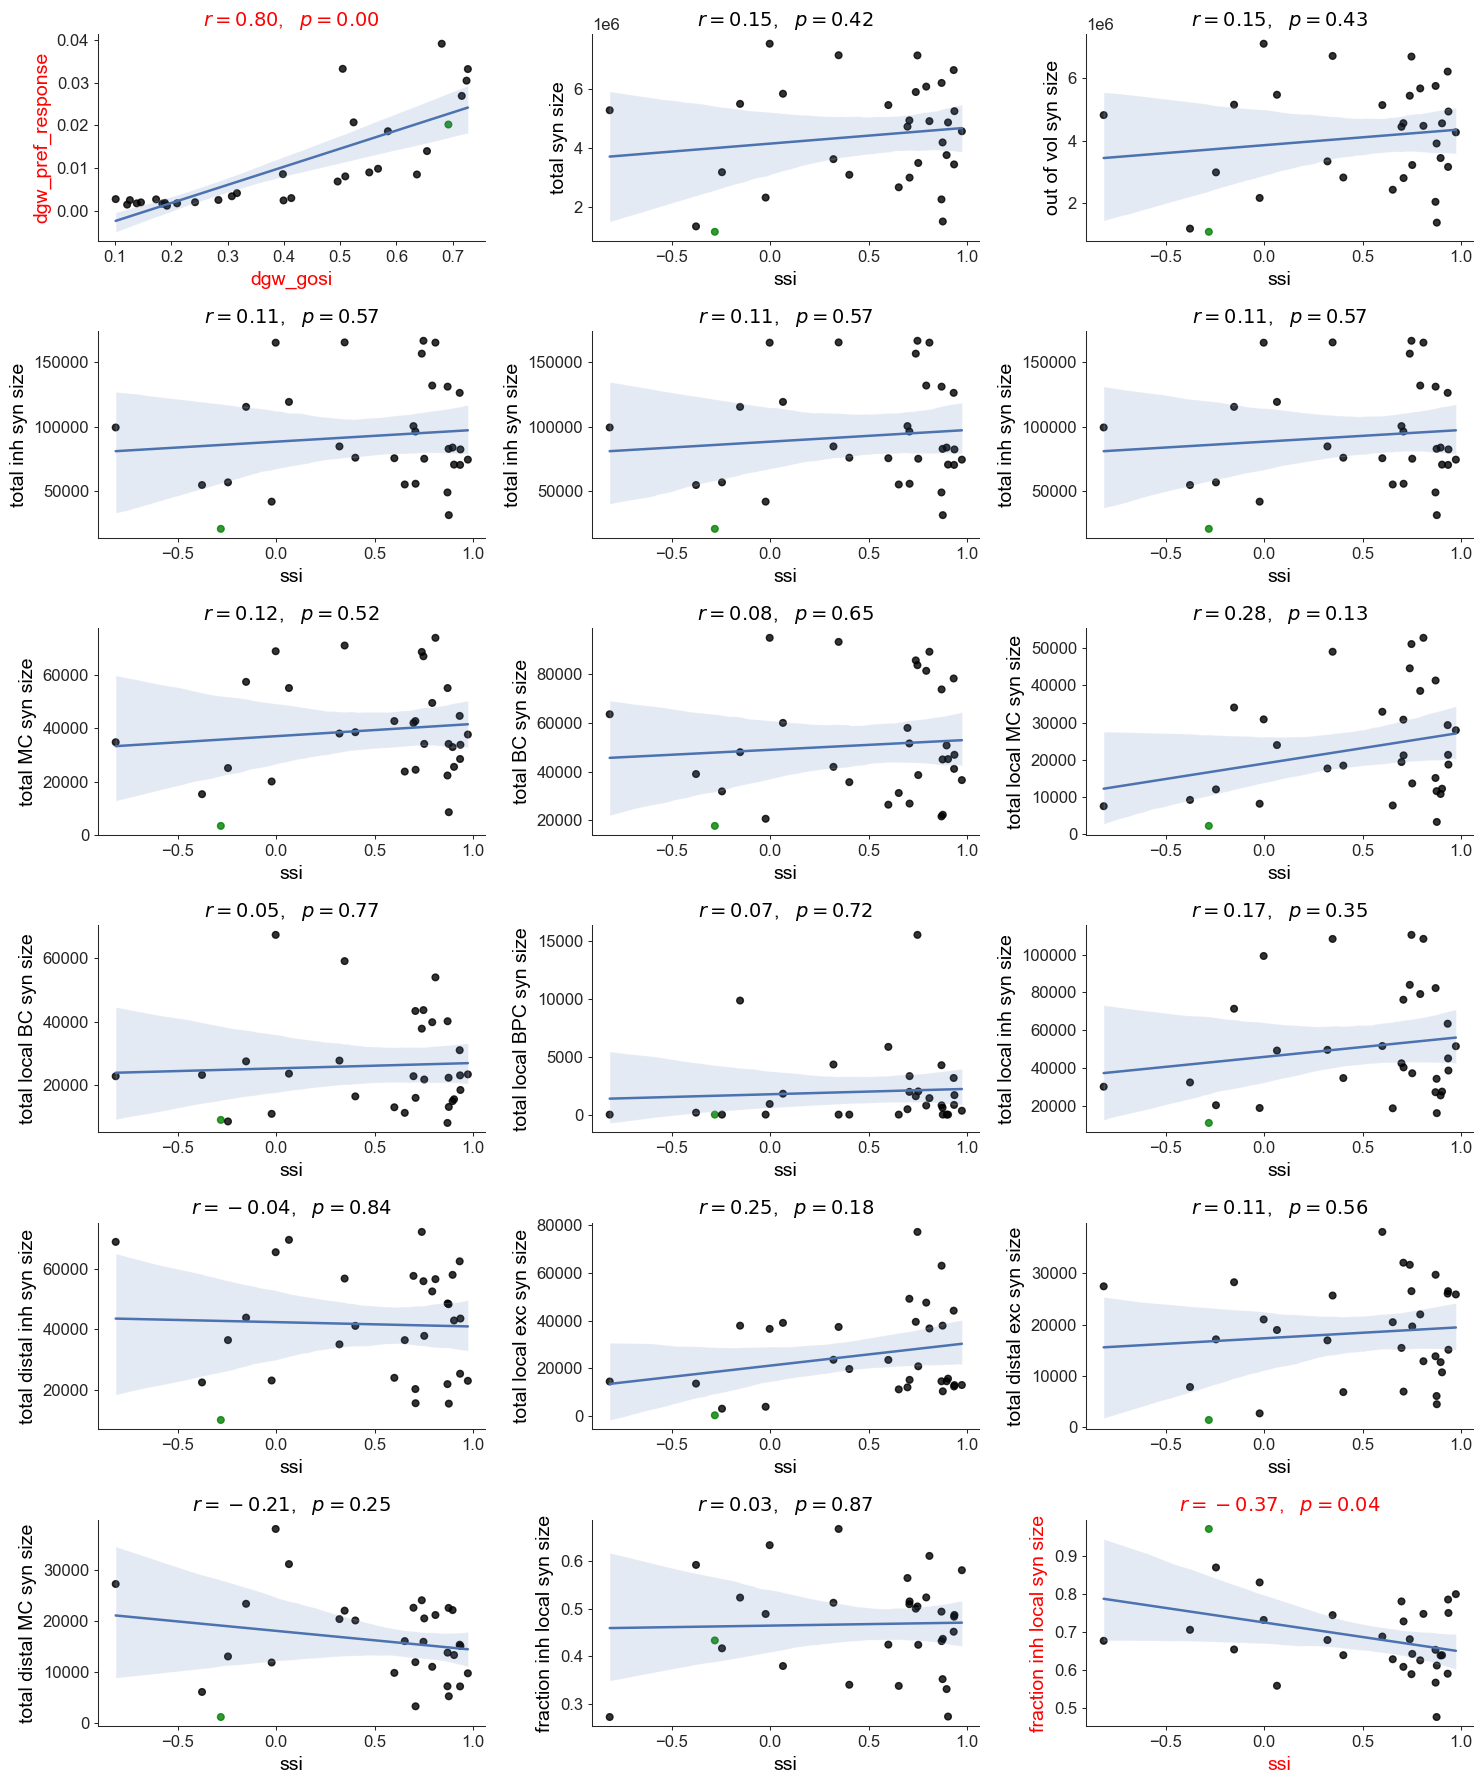

In [416]:
met = "dgw_gosi"
met = "ssi"
# met = "dgw_pref_response"
# met = "dgw_frac_responsive_trials"
# met = "dgw_lifetime_sparseness"

plot_config = [
    ("dgw_gosi", lambda root_id: metrics_em.at[root_id, "dgw_pref_response"], "dgw_pref_response"),

    (met, lambda root_id: syn_weight_by_type.loc[root_id].sum(), "total syn size"),
    (met, lambda root_id: syn_weight_by_type.at[root_id, "No Soma Attached"], "out of vol syn size"),
    (met, lambda root_id: syn_weight_by_type.loc[root_id, ["MC", "BC", "BPC"]].sum(), "total inh syn size"),
    (met, lambda root_id: syn_weight_by_type.loc[root_id, ["MC", "BC", "BPC"]].sum(), "total inh syn size"),
    (met, lambda root_id: syn_weight_by_type.loc[root_id, ["MC", "BC", "BPC"]].sum(), "total inh syn size"),
    (met, lambda root_id: syn_weight_by_type.loc[root_id, "MC"], "total MC syn size"),
    (met, lambda root_id: syn_weight_by_type.loc[root_id, "BC"], "total BC syn size"),
    # ("dgw_frac_responsive_trials", lambda root_id: syn_weight_by_type.loc[root_id, "PYC"], "total PYC syn size"),
    # ("ssi", lambda root_id: syn_weight_by_type.loc[root_id, "PYC"], "total PYC syn size"),
    # ("ssi", lambda root_id: syn_weight_by_type.loc[root_id, ["MC", "BC", "BPC"]].sum(), "total inh syn size"),
    # ("ssi", lambda root_id: syn_weight_by_type.loc[root_id, "MC"], "total MC syn size"),
    # ("ssi", lambda root_id: syn_weight_by_type.loc[root_id, "BC"], "total BC syn size"),
    # ("ssi", lambda root_id: total_local_input(root_id, cell_type="MC"), "total local MC syn size"),
    # ("ssi", lambda root_id: total_local_input(root_id, local=False, cell_type="MC"), "total distal MC syn size"),
    # ("ssi", lambda root_id: total_local_input(root_id, local=False, cell_type=["MC", "BC", "BPC"]), "total distal inh syn size"),
    # ("ssi", lambda root_id: total_local_input(root_id, local=True, cell_type="PYC"), "total local exc syn size"),
    # ("ssi", lambda root_id: total_local_input(root_id, local=False, cell_type="PYC"), "total distal exc syn size"),
    (met, lambda root_id: total_local_input(root_id, cell_type="MC"), "total local MC syn size"),
    (met, lambda root_id: total_local_input(root_id, cell_type="BC"), "total local BC syn size"),
    (met, lambda root_id: total_local_input(root_id, cell_type="BPC"), "total local BPC syn size"),
    (met, lambda root_id: total_local_input(root_id, local=True, cell_type=["MC", "BC", "BPC"]), "total local inh syn size"),
    (met, lambda root_id: total_local_input(root_id, local=False, cell_type=["MC", "BC", "BPC"]), "total distal inh syn size"),
    (met, lambda root_id: total_local_input(root_id, local=True, cell_type="PYC"), "total local exc syn size"),
    (met, lambda root_id: total_local_input(root_id, local=False, cell_type="PYC"), "total distal exc syn size"),
    (met, lambda root_id: total_local_input(root_id, local=False, cell_type="MC"), "total distal MC syn size"),
    # (met, lambda root_id: total_local_input(root_id, local=True, cell_type="PYC") + total_local_input(root_id, local=True, cell_type=["MC", "BC", "BPC"]), "total local E-I syn size"),
    # (met, lambda root_id: total_local_input(root_id, local=False, cell_type="PYC") + total_local_input(root_id, local=False, cell_type=["MC", "BC", "BPC"]), "total distal E-I syn size"),
    (met, lambda root_id: total_local_input(root_id, local=True, cell_type=["MC", "BC", "BPC"]) / total_local_input(root_id, local=True), "fraction inh local syn size"),
    (met, lambda root_id: total_local_input(root_id, local=True, cell_type=["MC", "BC", "BPC"]) / (total_local_input(root_id, local=True, cell_type=["MC", "BC", "BPC", "PYC"])), "fraction inh local syn size"),
]

ncols = 3
nrows = int(np.ceil(len(plot_config) / ncols))
fig, axs = plt.subplots(figsize=(5*ncols, 3*nrows), nrows=nrows, ncols=ncols)
axs = axs.flatten()

for i, ax in enumerate(axs):

    if i < len(plot_config):
        x_metric, y_fn, y_label = plot_config[i]
        x, y = [], [],
        c = []
        for root_id in dgw_resp_root_ids:
            x.append(metrics_em.at[root_id, x_metric])
            y.append(y_fn(root_id))
            c.append("green" if root_id in sample_root_ids else "black")

        sns.regplot(x=x, y=y, ax=ax, scatter_kws=dict(color=c))
        r, p = scipy.stats.pearsonr(x, y)
        textcolor = "red" if p < 0.05 else "black"
        ax.set_title(f"$r = {r:.2f}$,   $p = {p:.2f}$", color=textcolor)
        ax.set_xlabel(x_metric, fontsize=14, color=textcolor)
        ax.set_ylabel(y_label, fontsize=14, color=textcolor)
    else:
        ax.axis("off")

fig.tight_layout()

In [415]:
metrics_em.at[root_id, "ssi"]

-0.281959452517374

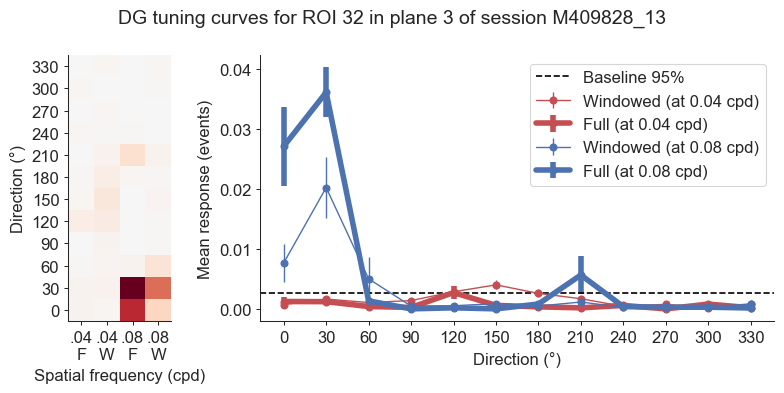

In [419]:
root_id = sample_root_ids[0]
plane, roi = metrics_em.at[root_id, "plane"], metrics_em.at[root_id, "roi"]
session = ophys_client.load_ophys_session(mouse=metrics_em.at[root_id, "mouse"], column=metrics_em.at[root_id, "column"], volume=metrics_em.at[root_id, "volume"])

dgw = DriftingGratings(session, plane, dg_type="windowed", quick_load=True)
dgf = DriftingGratings(session, plane, dg_type="full", quick_load=True)
dgw.plot_roi_tuning_curves(roi, dg_other=dgf)